In [1]:
import os
import pandas as pd
import warnings

%matplotlib inline 

warnings.filterwarnings("ignore")

In [2]:
data_dir = r'C:\Users\Yijia\GITPROJ\JQXXXX\kaggle\modelers\yw\Data'
train_csv_path = os.path.join(data_dir, 'train.csv')

In [3]:
train_df = pd.read_csv(train_csv_path)
# Data Description:
# https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/data

In [4]:
print(train_df.head())
train_df.describe()

# === > DepartmentDescription, Weekday should be re-mapped into numbers

   TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   
3        26            8  Friday  2.238404e+09          2   
4        26            8  Friday  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0  


,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,647054.000000,647054.000000,6.429250e+05,647054.000000,642925.000000
mean,58.584511,96167.640078,3.060698e+10,1.108878,3726.884567
std,157.635533,55545.485154,9.120134e+10,0.700776,2780.966158
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49268.000000,3.400001e+09,1.000000,1404.000000
50%,39.000000,97074.000000,7.050103e+09,1.000000,3352.000000
75%,40.000000,144316.000000,3.006531e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A513F98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000016022828>]], dtype=object)

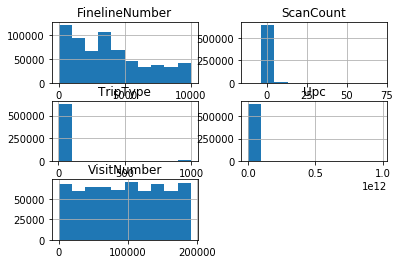

In [50]:
train_df.hist()

In [52]:
df = train_df[['Upc']]
df['Upc_count'] = train_df.groupby('Upc')['Upc'].transform(sum)
df.groupby('Upc').count().sort_values(by='Upc_count',ascending=False).head()

# ===> Upc should be re categorized to range(len(unique_Upc))
# The UPC (Universal Product Number) symbol is the barcode representation of the GTIN-12 which consists of twelve numeric characters that uniquely identify a company's individual product.
# http://www.gtin.info/upc/

,Upc_count
Upc,
4.011000e+03,7657
6.053886e+10,2501
7.874235e+09,2067
7.874235e+09,1883
4.046000e+03,1652


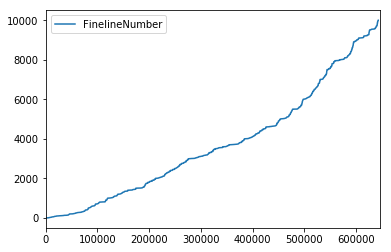

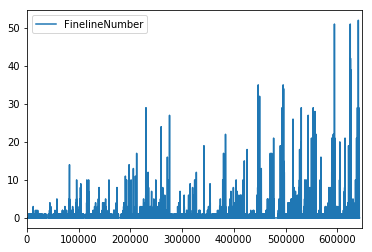

In [62]:
train_df[['FinelineNumber']].sort_values(by='FinelineNumber', ascending=True).reset_index(drop=True).plot()
train_df[['FinelineNumber']].sort_values(by='FinelineNumber', ascending=True).reset_index(drop=True).diff(1).plot()

# ===> FinlineNumber is already some well scaled number
# Fineline is a Walmart assigned item group, Fineline is one level above the item.
# http://www.suppliercommunity.org/showthread.php?tid=16

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Auto encodes any dataframe column of type category or object.
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

category_cols = ['DepartmentDescription', 'Weekday', 'Upc', 'FinlineNumber']
train_df_1 = one_hot(train_df, cols=category_cols)

In [6]:
# distinct number counts
df_unique_value_counts = pd.DataFrame([], index=train_df.columns, columns=['unique_values_count'])
for col in train_df.columns:
    df_unique_value_counts.ix[col] = len(train_df[[col]].drop_duplicates())

df_unique_value_counts.ix['all_orig'] = len(train_df)    
df_unique_value_counts.ix['all_unique'] = len(train_df.drop_duplicates())    
print(df_unique_value_counts)    
print(train_df.head())

                      unique_values_count
TripType                               38
VisitNumber                         95674
Weekday                                 7
Upc                                 97715
ScanCount                              39
DepartmentDescription                  69
FinelineNumber                       5196
all_orig                           647054
all_unique                         641350
   TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   
3        26            8  Friday  2.238404e+09          2   
4        26            8  Friday  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0 

In [13]:
print(len(train_df[['VisitNumber', 'TripType']]))
print(len(train_df[['VisitNumber', 'TripType', 'Weekday']]))
print(len(train_df['VisitNumber']))

647054
647054
647054


In [17]:
train_df.groupby(['VisitNumber']).count().head()

,TripType,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
VisitNumber,,,,,,
5,1,1,1,1,1,1
7,2,2,2,2,2,2
8,23,23,22,23,22,22
9,3,3,3,3,3,3
10,3,3,3,3,3,3


In [14]:
def apply_func_groupby_VisitNumber(df):
    trip_type = df[:,0].mean()
    weekday = df[:,1].mean()
    upc = df[:,2].count()
    scan_count = df[:,3].sum()
    department_dscription = df[:,4].drop_duplicates().count()
    finline_number = df[:,5].drop_duplicates().count()
    res = [trip_type, weekday, upc, scan_count, department_dscription, finline_number]
    return res

In [ ]:
train_df.groupby(['VisitNumber']).apply(apply_func_groupby_VisitNumber)